In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys
import torch.nn.functional as F


sys.path.append('../..')
import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from utils import path_wrapper, plotter

### 0 Loading Data

In [2]:
future_index= 'ic'
params = {
    "batch_size": 64,
    "hidden_size": 128,
    "seq_length": 8,
    "weight_decay": 0.03699014272607559,
    "num_layers": 2,
    "learning_rate": 0.001264079267383521,
#     "learning_rate": 0.0006264079267383521,
#     "dropout_prob": 0.0049846528896436
    "dropout_prob": 0.2149846528896436
}

In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device, bidirectional=False):
        super().__init__()

        self.name = 'RNN'
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.device = device

        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 =  nn.Linear(128, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers, batch_size, self.hidden_size)
        return torch.zeros(state_dim).to(self.device)

    def forward(self, x, states):
        x, h = self.rnn(x, states)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x[:, -1, :], h

### 1 Define LSTM Model

In [5]:
def eval_model(model, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])
        states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            states = states.detach()
            y_pred, states = model(x_batch, states)

            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {model.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

    result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
    plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 2 Create Training Func

In [6]:
def train(train_data_loader, model, criterion, optimizer, params):
    glog.info(f"Start Training Model")

    # Set to train mode
    model.train()
    training_states = model.init_hidden_states(params['batch_size'])
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        # Truncated Backpropagation
        training_states = training_states.detach()
        # Make prediction
        y_pred, training_states = model(x_batch, training_states)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    glog.info(f"End Training Model")

    train_loss_average = running_train_loss / len(train_data_loader)
    return model, train_loss_average

In [7]:
def validate(val_data_loader, model, criterion, params):
    # Set to eval mode
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        val_states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            val_states = val_states.detach() 
            y_pred, val_states = model(x_batch, val_states)

            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

### 3 Run Training

In [8]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDatasetRecurrent(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDatasetRecurrent(data=val_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDatasetRecurrent(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [9]:

# create model instance
model = RNN(
    input_size=len(train_dataset.features_list),
    hidden_size=params['hidden_size'],
    num_layers=params['num_layers'],
    output_size=xfinai_config.model_config['rnn']['output_size'],
    dropout_prob=params['dropout_prob'],
    device=device
).to(device)

criterion = nn.MSELoss()

optimizer = optim.AdamW(model.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = xfinai_config.model_config['rnn']['epochs']

print(model)
train_losses = []
val_losses = []
# train the model
for epoch in range(epochs):
    trained_model, train_score = train(train_data_loader=train_loader, model=model, criterion=criterion,
                                       optimizer=optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, model=trained_model, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
    train_losses.append(train_score)
    val_losses.append(val_score)

I0313 19:32:05.447519 16876 911631254.py:2] Start Training Model


RNN(
  (rnn): RNN(28, 128, num_layers=2, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


I0313 19:32:09.177505 16876 911631254.py:30] End Training Model
I0313 19:32:11.398129 16876 911631254.py:2] Start Training Model


Epoch :0 train_score 0.0013615524249661786 val_score 0.003511403075365173


I0313 19:32:14.189258 16876 911631254.py:30] End Training Model
I0313 19:32:16.352446 16876 911631254.py:2] Start Training Model


Epoch :1 train_score 0.0002813474284266704 val_score 0.0002779699175805255


I0313 19:32:19.118703 16876 911631254.py:30] End Training Model
I0313 19:32:21.308084 16876 911631254.py:2] Start Training Model


Epoch :2 train_score 4.7453204514952704e-05 val_score 7.995858046844409e-05


I0313 19:32:24.077469 16876 911631254.py:30] End Training Model
I0313 19:32:26.223866 16876 911631254.py:2] Start Training Model


Epoch :3 train_score 3.556068161550194e-05 val_score 3.148179731114992e-05


I0313 19:32:28.980173 16876 911631254.py:30] End Training Model
I0313 19:32:31.154205 16876 911631254.py:2] Start Training Model


Epoch :4 train_score 9.328322978883709e-06 val_score 1.6471435409239976e-05


I0313 19:32:33.914972 16876 911631254.py:30] End Training Model
I0313 19:32:36.108564 16876 911631254.py:2] Start Training Model


Epoch :5 train_score 4.954703525820255e-06 val_score 9.144166275793145e-06


I0313 19:32:38.900176 16876 911631254.py:30] End Training Model
I0313 19:32:41.067673 16876 911631254.py:2] Start Training Model


Epoch :6 train_score 3.4964087310877053e-06 val_score 5.992934881039124e-06


I0313 19:32:43.849957 16876 911631254.py:30] End Training Model
I0313 19:32:46.003315 16876 911631254.py:2] Start Training Model


Epoch :7 train_score 2.4903884110472063e-06 val_score 4.743193934355704e-06


I0313 19:32:48.807657 16876 911631254.py:30] End Training Model
I0313 19:32:50.953196 16876 911631254.py:2] Start Training Model


Epoch :8 train_score 1.74265730434032e-06 val_score 4.201661420995214e-06


I0313 19:32:53.770206 16876 911631254.py:30] End Training Model


Epoch :9 train_score 1.3057923191275643e-06 val_score 3.877451506233573e-06


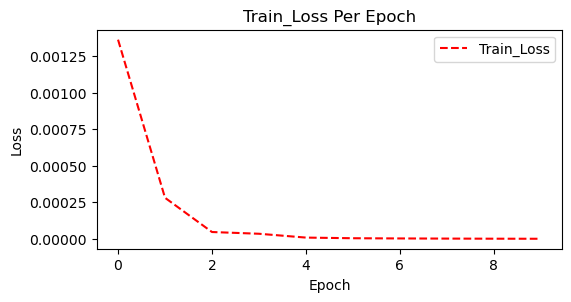

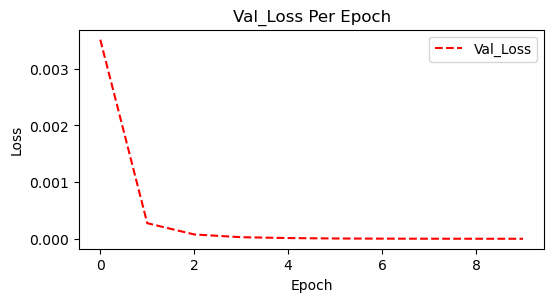

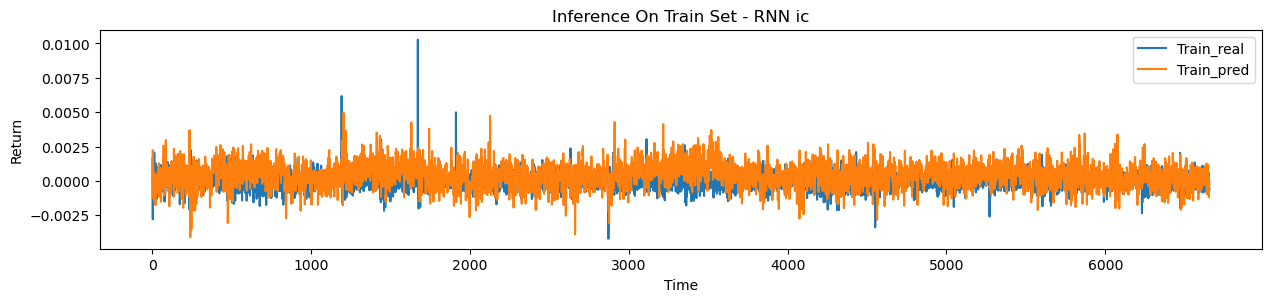

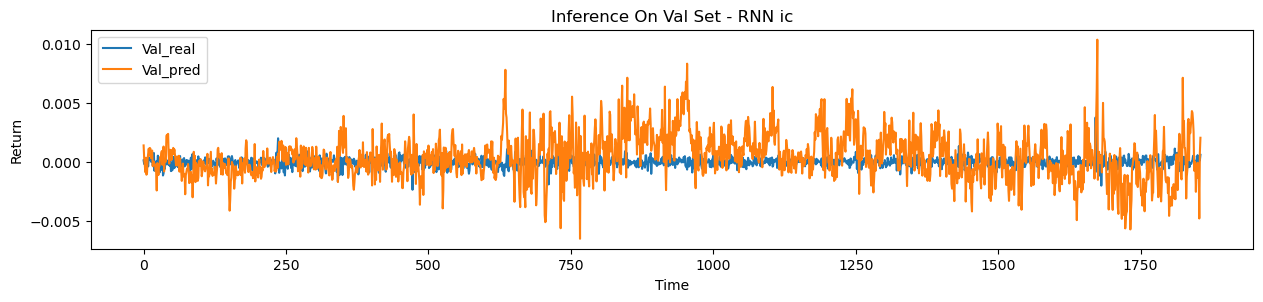

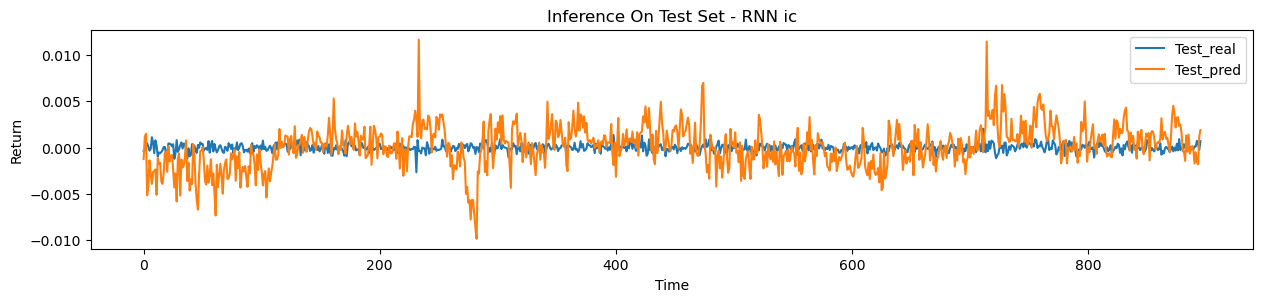

In [10]:
# # save the model
# save_model(trained_model, future_index)

# plot losses
plotter.plot_loss(train_losses, epochs, 'Train_Loss', trained_model.name, future_index)
plotter.plot_loss(val_losses, epochs, 'Val_Loss', trained_model.name, future_index)

# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['Train', 'Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)